In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
def load_jsonl(fname):
    fin = open(fname, encoding="utf-8")
    data = []
    for line in fin:
        d = json.loads(line.strip())
        data.append(d)

    return data

def save_jsonl(data, filename):
    with open(filename, "w", encoding="utf-8") as fo:
        for idx, d in enumerate(data):
            fo.write(json.dumps(d, ensure_ascii=False))
            fo.write("\n")

In [5]:
ls ..

Datasets/                             few-shot_WangchanBERTa.py
Figures/                              few-shot_WangchanBERTa_MST.py
LICENSE.md                            fine-tune_WangchanBERTa.py
LSTMDataset.py                        fine-tune_WangchanBERTa_MST.py
LSTMModel.py                          notebooks/
MAEClassifier.py                      preprocess_training_text_fasttext.py
Models/                               run_LSTM.sh
README.md                             run_LSTMv2.sh
Results/                              run_WangchanBERTa.sh*
Seq2Seq Model.ipynb                   test_mispelling_correction.jsonl
SequenceClassificationDataset.py      train_LSTM.py
THSarabunNew.ttf                      train_LSTM_MST.py
WangchanBERTaArgs.py                  train_fasttext.py
WangchanBERTaDataset.py               train_mispelling_dection.jsonl
WangchanBERTaModel.py                 util.py


In [6]:
data = []
DIR = "../Datasets/WisesightSentiment/few-shot/"
for i in range(1, 5+1):
    d = load_jsonl(f"{DIR}/misp{i}/all.jsonl")
    for sent in d:
        del sent["id"]
        sent["meta"]["part"] = i
    d = pd.DataFrame(d)
    data.append(d)

In [7]:
print("#Annotators:", len(data))

#Annotators: 5


# Inter-Annotator Agreement

<img width="500px" src="https://miro.medium.com/max/875/1*mHB6Ciljb4OnOacNWgc0aw.png">

In [8]:
import sklearn
from sklearn.metrics import cohen_kappa_score
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

In [9]:
# from sklearn.metrics import cohen_kappa_score
# y_true = [2, 0, 2, 2, 0, 1]
# y_pred = [0, 0, 2, 2, 0, 2]
# 

In [10]:
# from itertools import combinations
# pairs = list(combinations(range(5), 2))

### Sentence-wise

In [11]:
# import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb
import numpy as np

def has_misspelling(val):
    return int(len(val)==0)

mat = []
for p1 in range(5):
    row = []
    for p2 in range(5):
        if p2 >= p1:
            row.append(0)
            continue
        
        d1 = data[p1]
        d2 = data[p2]

        d = d1.merge(d2, on="data", how="inner")

        m1 = d["label_x"].apply(has_misspelling)
        m2 = d["label_y"].apply(has_misspelling)

        row.append(cohen_kappa_score(m1, m2))
        print(p1, p2, cohen_kappa_score(m1, m2), (m1!=m2).sum())
    mat.append(row)



1 0 0.5523220467574752 198
2 0 0.7426610751048417 99
2 1 0.5771654255479515 187
3 0 0.716058175275508 101
3 1 0.5335973813766809 196
3 2 0.8289207987435495 61
4 0 0.686227814697411 130
4 1 0.6716584644183449 145
4 2 0.6925512821207997 126
4 3 0.7107333582401161 117


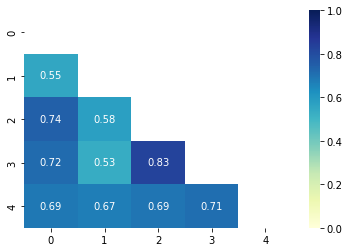

In [13]:
mask = np.triu(np.ones_like(mat))
# # plotting a triangle correlation heatmap
dataplot = sb.heatmap(mat, cmap="YlGnBu", annot=True, mask=mask, vmin=0, vmax=1)
fig = dataplot.get_figure()
# fig.savefig("../Figures/iaa1.png")

### Token-wise

In [14]:
def get_segments(text, labels):
    seg = []
    pt = 0
    
    labels = sorted(labels, key=lambda x: x[0], reverse=False)
    for l in labels:
        seg.append({"text": text[pt:l[0]], "misp": False, "int":False, "s": pt, "t":l[0]})
        mint = (l[2]=='ตั้งใจ')
        seg.append({"text": text[l[0]:l[1]], "misp": True, "int":mint, "s": l[0], "t":l[1]})
        pt = l[1]
    
    seg.append({"text": text[pt:], "misp": False, "int":False, "s": pt, "t":len(text)})
    
    length = sum([len(s["text"]) for s in seg])
    assert(length==len(text))
    return seg

def overlap_segments(text, segments):
    idx = set()
    for seg in segments:
        for s in seg:
            idx.add(s["s"])
            idx.add(s["t"])
    
    idx = sorted(idx)
    newseg = []
    for i, _ in enumerate(idx):
        if i==0:
            continue
            
        newseg.append({
            "text": text[idx[i-1]:idx[i]], 
            "s": idx[i-1], 
            "t": idx[i],
        })
    
    o = []
    for seg in segments:
        ns = []
        for s in newseg:
            for ref in seg:
                if s["s"] >= ref["s"] and  s["s"] < ref["t"]:
                    break

            ns.append({
                "text": s["text"], 
                "misp": ref["misp"], 
                "int": ref["int"], 
                "s": s["s"], 
                "t": s["t"],
            })
        o.append(ns)
        
    return o

mat = []
for p1 in range(5):
    row = []
    for p2 in range(5):
        if p2 >= p1:
            row.append(0)
            continue
        
        d1 = data[p1]
        d2 = data[p2]

        d = d1.merge(d2, on="data", how="inner")
        s1 = []
        s2 = []
        for idx, sent in d.iterrows():
            seg1 = get_segments(sent["data"], sent["label_x"])
            seg2 = get_segments(sent["data"], sent["label_y"])
            seg = overlap_segments(sent["data"], [seg1, seg2])
            
            for s in seg[0]:
                if not s["misp"]:
                    s1.append(0)
                elif s["int"]:
                    s1.append(1)
                else:
                    s1.append(2)
                    
            for s in seg[1]:
                if not s["misp"]:
                    s2.append(0)
                elif s["int"]:
                    s2.append(1)
                else:
                    s2.append(2)
            

        row.append(cohen_kappa_score(s1, s2))
        print(p1, p2, cohen_kappa_score(s1, s2), (np.array(s1)!=np.array(s2)).sum()*100/len(s1))
        
    mat.append(row)

1 0 0.4288299430560263 23.729582577132486
2 0 0.5815938566308756 15.927654609101516
2 1 0.4351471003109848 23.42557251908397
3 0 0.5879560516029422 14.821763602251407
3 1 0.38893936247534 24.719101123595507
3 2 0.6977831112233941 11.285266457680251
4 0 0.5435488529154757 18.80988401412002
4 1 0.5160136079886379 21.026785714285715
4 2 0.5227718580198998 19.383490073145246
4 3 0.52317363419996 19.20424403183024


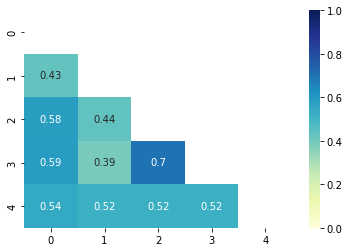

In [15]:
mask = np.triu(np.ones_like(mat))
# # plotting a triangle correlation heatmap
dataplot = sb.heatmap(mat, cmap="YlGnBu", annot=True, mask=mask, vmin=0, vmax=1)
fig = dataplot.get_figure()
# fig.savefig("Figures/iaa2.png")

# Intention Labelling Entropy across Sentences

In [16]:
from pythainlp.tokenize import word_tokenize
engine = "deepcut"
# word_tokenize("ฉันรักแมว", engine=engine)

In [17]:
reference = load_jsonl(f"{DIR}/missplling_train_wisesight_samples.jsonl")

In [18]:
reference = pd.DataFrame(reference)

In [19]:
O = reference
for i, d in enumerate(data):
    d = d[["data", "label"]]
    d.columns = ["text", f"misp{i}"]
    O = O.merge(d, on="text", how="left")

In [20]:
import copy
from tqdm import tqdm
from itertools import groupby

def norm_word(word):
    groups = [list(s) for _, s in groupby(word)]
    ch = []
    extraToken = ""
    for g in groups:
        if len(g)>=3:
            extraToken = "<rep>"
        ch.append(g[0])  
        
    word = "".join(ch)+extraToken
    return word

def tolabel(n):
    if n==2:
        return "neg"
    elif n==1:
        return "neu"
    elif n==0:
        return "pos"
    else:
        raise(f"Unknow label: {n}")
        
merged = []
for idx, row in tqdm(O.iterrows(), total=len(O)):
    segs = []
    for i in range(5):
        if pd.isna([row[f"misp{i}"]]).all():
            seg = get_segments(row["text"], [])
        else:
            seg = get_segments(row["text"], row[f"misp{i}"])
        
        segs.append(seg)
    
#     seg2 = get_segments(sent["data"], sent["label_y"])
    o = overlap_segments(row["text"], segs)
    tokens = []
    # if row["text"]=="อีดออกกก ฟังเพลงล้ะมีโฆษณาเอ็มเคชีสซิ๊ดเเซ่บคือเหี้ยใร":
    #     print(o)
    for i in range(len(o[0])):
        s = copy.copy(o[0][i])
        
        mispProb = 0
        intProb = 0
        # assert(len(o)==5)
        for j in range(len(o)):
            if (o[j][i]["misp"]):
                mispProb += 1/3
            
            if (o[j][i]["int"]):
                intProb += 1/3
                
        assert(mispProb <= 1)
        assert(intProb <= 1)
        
        if (mispProb < 0.5) and (intProb < 0.5):
            continue
        

        s["int"] = intProb
        s["msp"] = mispProb
        
        if s["text"]=="ใร":
            print(s, row["text"])
        # s["misp"] = s["text"]
        # del s["text"]
        # s["int"] = (intProb > 0.5)
        
        
#         s["tokens"] = word_tokenize(s["text"], engine=engine)
        s["corr"] = None
        tokens.append(s)

    merged.append({
        "text": row["text"],
        "category": tolabel(row["meta"]["category"]),
        "misp_tokens": tokens
    })
    
merged = pd.DataFrame(merged)

# {"corr": "ไหม", "misp": "มั้ย", "int": true, "s": 67, "t": 71}

 37%|█████████████▌                       | 1097/3000 [00:00<00:00, 5594.69it/s]

{'text': 'ใร', 'misp': True, 'int': 0.6666666666666666, 's': 52, 't': 54, 'msp': 0.6666666666666666} อีดออกกก ฟังเพลงล้ะมีโฆษณาเอ็มเคชีสซิ๊ดเเซ่บคือเหี้ยใร


100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 5912.92it/s]

{'text': 'ใร', 'misp': False, 'int': 0.6666666666666666, 's': 29, 't': 31, 'msp': 0.6666666666666666} มาสด้าฟ้องลูกค้ากลับเพราะเหตุใรไม่รู้ เเต่ฮอนด้าเขาฟ้องเพราะว่ามันไปยืนบนรถในมอเตอร์เอ็กซ์โป ที่ที่เขาขายรถ ไม่ฟ้องก็เเย่ ที่เงียบเพราะไม่ผิดที่ฟ้อง เเต่มาสด้านี่ อืมมม เเก้ไขยังไม่รุอีนํ้าดันเนี่ย เเก้เหอะ


In [21]:
tokenized = load_jsonl(f"{DIR}/../tokenized_train-misp-3000.jsonl")
tokenized = pd.DataFrame(tokenized)

In [22]:
# merged

In [23]:
# tokenized

In [24]:
sents = merged.merge(tokenized[["text", "segments"]], on="text")

In [25]:
from collections import defaultdict

cnt = defaultdict(int)
cntmsp = defaultdict(list)
cntint = defaultdict(list)

def cal_entropy(labels):
    s = pd.Series(labels)
    counts = s.value_counts()
    return entropy(counts)

for idx, sent in sents.iterrows():
    for seg in sent["segments"]:
        for w in seg[0]:
            cnt[norm_word(w)] += 1
            
    for m in sent["misp_tokens"]:
        norm = norm_word(m["text"])
        # cntmsp[norm].append(int(m["msp"] > 0.5))
        cntint[norm].append(int(m["int"] > 0.5))
        # cntint[norm].append(m["int"])

In [26]:
from scipy.stats import entropy

mispconsis = {}
for m in cntint:
    if (cnt[m] < 5):
        continue 
        
    mispconsis[m] = cal_entropy(cntint[m])
# mispconsis

In [51]:
mispconsis

{'ค่า<rep>': 0.0,
 'สัด': 0.0,
 'แม่ง': 0.0,
 'ก้': 0.0,
 'ใจ': 0.6365141682948128,
 'จิ': 0.0,
 ' ': 0.25731864054383163,
 'น้า<rep>': 0.0,
 'กุ': 0.0,
 'แร้ว': 0.0,
 'ค่ะ': 0.2337916587064593,
 'ยุ': 0.0,
 'น่ะ': 0.0,
 'คะ': 0.47413931305783735,
 'แม่': 0.0,
 'ง': 0.0,
 'ไร้': 0.0,
 'คร้าบ': 0.0,
 'ใด้': 0.0,
 'สัส': 0.0,
 'กิน': 0.0,
 'เด๋ว': 0.0,
 'อยาก<rep>': 0.0,
 'กิน<rep>': 0.0,
 'อิ': 0.0,
 'เรย': 0.0,
 'สุข': 0.0,
 'ไป<rep>': 0.0,
 'มาก<rep>': 0.0,
 'หิว<rep>': 0.0,
 'คับ': 0.0,
 'กะ': 0.0,
 'จิง': 0.0,
 'ไม': 0.6931471805599453,
 'จิงๆ': 0.0,
 'ก้อ': 0.0,
 'อยาก': 0.0,
 'ฮือ<rep>': 0.0,
 'มึง': 0.0,
 'เปน': 0.0,
 'หรา': 0.0,
 'ข้อ': 0.0,
 'มะ': 0.0,
 'เสมอ': 0.0,
 'กะทะ': 0.0,
 'ด้วย': 0.0,
 'ย': 0.0,
 'จ้า<rep>': 0.0,
 'เฉย': 0.0,
 'แล้ว': 0.6365141682948128,
 'เทอ': 0.0,
 'แล้ว<rep>': 0.0,
 'บุหรี': 0.0,
 'เลย': 0.0,
 'รุ้': 0.410116318288409,
 'ตัง': 0.6365141682948128,
 'โว้ย': 0.5623351446188083,
 'ขาย': 0.0,
 'ฟิน': 0.6931471805599453,
 'ติด': 0.0,
 'เสา': 0.0,
 'น๊า':

In [52]:
values = {k: v for k, v in sorted(mispconsis.items(), key=lambda item: -item[1])}
x = []
y = []
for i, k in enumerate(values):
    x.append(k)
    y.append(values[k])
#     print(k, values[k])
#     if i > 10:
#         break

In [62]:
# # import warnings
# # warnings.filterwarnings("ignore")

# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# font_dirs = ["../"]
# font_files = fm.findSystemFonts(fontpaths=font_dirs)
# for font_file in font_files:
#     fm.fontManager.addfont(font_file)

In [63]:
# # set font
# import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'TH Sarabun New'
# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0

# # mx = len(x)
# # plt.ylim(0, 1)
# # plt.xticks(rotation=90)
# # plt.rcParams["figure.figsize"] = (20,3)
# # plt.xticks([], [])
# # plt.bar(x[0:mx], y[0:mx])

In [64]:
# y

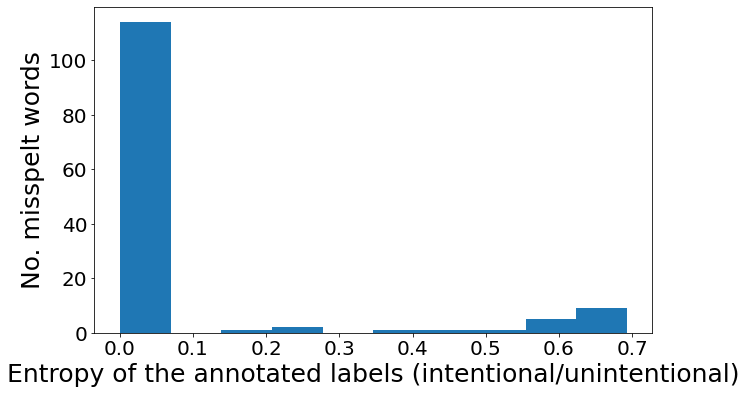

In [66]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 25})

plt.ylabel("No. misspelt words")
plt.xlabel("Entropy of the annotated labels (intentional/unintentional)")
plt.hist(y, bins=10)
plt.savefig('../Figures/int_entropy.png')

In [34]:
# save_jsonl(merged, f"{DIR}/train-misp-3000.jsonl")

In [35]:
# from collections import defaultdict
# labels = defaultdict(int)

# for sent in unified:
#     labels[sent["category"]] += 1
# #     break

# labels

# Term Frequency

In [36]:
from collections import defaultdict

cnt = defaultdict(int)
misp = defaultdict(int)

for idx, sent in sents.iterrows():
    mispFound = False
    for seg in sent["segments"]:
        for m, c in zip(seg[0], seg[1]):
            if m!=c:
                mispFound = True
                cnt["misp"] += 1
                n = norm_word(m)
                misp[n] += 1
            cnt["token"] += 1
            
    if mispFound:
        cnt["sent"] += 1
    # break?

In [37]:
print("%Mispelling Sentence:", cnt["sent"]*100/len(sents), cnt["sent"])

print()
print("#Misspelling:", cnt["misp"])
print("%Misspelling:", cnt["misp"]*100/cnt["token"])
print("#Unique Misspelling Tokens:", len(misp))

%Mispelling Sentence: 32.36666666666667 971

#Misspelling: 1484
%Misspelling: 1.8941376185431478
#Unique Misspelling Tokens: 728


In [38]:
# from transformers import XLMRobertaTokenizerFast
# tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')

# import itertools

# cnt["misp_sub"] = 0
# cnt["corr_sub"] = 0
# unk = tokenizer.convert_tokens_to_ids(["<unk>"])[0]
# for sent in trainmisp:
#     s = [list(zip(seg[0], seg[1])) for seg in sent["segments"]]
#     tokens = list(itertools.chain(*s))
# #     misptokens = [t[0] for t in tokens]
# #     midx = tokenizer.convert_tokens_to_ids(misptokens)
# #     for i in range(len(midx)):
# #         if midx[i]==unk:
# #             t = tokenizer.tokenize("_"+misptokens[i])[1:]
# #             cnt["misp_sub"] += len(t)
# #         else:
# #             cnt["misp_sub"] += 1
    
#     cnt["misp_sub"] += len(tokens)
#     cnt["corr_sub"] += len(tokenizer.tokenize(sent["text"]))
#     # break

# print("%Subtokens Different", abs(cnt["misp_sub"]-cnt["corr_sub"])*100/cnt["corr_sub"])

## Most common misspelling words

In [39]:
sortedmisp = {k: v for k, v in sorted(misp.items(), key=lambda item: -item[1])}

for i, k in enumerate(sortedmisp):
    print(k, sortedmisp[k])
    if i > 10:
        break

แม่ง 63
คับ 62
กุ 49
สัส 24
มาก<rep> 24
อิ 23
กิน<rep> 19
เค้า 19
มั้ย 19
ก้ 18
ก้อ 18
ค่ะ 16


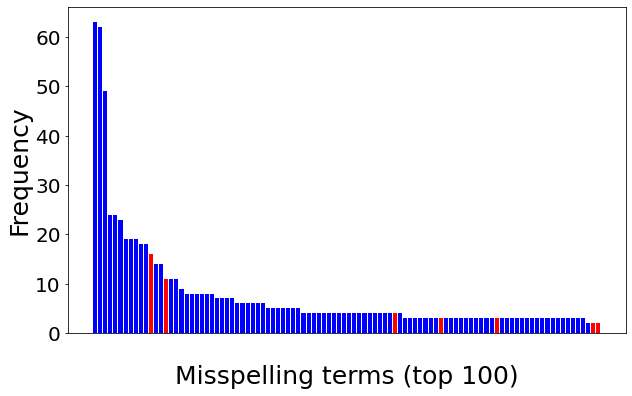

In [43]:
x = [x for x in sortedmisp]
y = [sortedmisp[k] for k in sortedmisp]

mint = [int(np.average(cntint[k]) > 0.5) for k in sortedmisp]
c = ['b' if i==1 else 'r' for i in mint]

mx = 100
# plt.ylim(0, 1.2)
# plt.xticks(rotation=90)
# plt.rcParams["figure.figsize"] = (20,3)
plt.xticks([], [])
plt.bar(x[0:mx], y[0:mx], color=c[0:mx])
plt.ylabel("Frequency")
plt.xlabel(f"\nMisspelling terms (top {mx})")
plt.savefig("../Figures/tf.png")


# _x = np.array(range(len(x)))
# _y = (np.full(len(x), y[0]))/(_x+1) 
# plt.plot(_x[0:mx], _y[0:mx], "r")

In [243]:
print("Common mispelling")
cc = 0
obs = 0
for i in range(len(x)):
    if cc <= 20:
        print(cc, x[i], y[i], 'int' if mint[i]==1 else 'un')
    cc += 1
    obs += y[i]

Common mispelling
0 แม่ง 63 int
1 คับ 62 int
2 กุ 49 int
3 สัส 24 int
4 มาก<rep> 24 int
5 อิ 23 int
6 กิน<rep> 19 int
7 เค้า 19 int
8 มั้ย 19 int
9 ก้ 18 int
10 ก้อ 18 int
11 ค่ะ 16 un
12   14 int
13 เปน 14 int
14 คะ 11 un
15 จิง 11 int
16 จ้า<rep> 11 int
17 มะ 9 int
18 แร้ว 8 int
19 ยุ 8 int
20 คร้าบ 8 int


In [240]:
print("Common intentional mispelling")
cc = 0
obs = 0
for i in range(len(x)):
    if mint[i]==1:
        if cc <= 15:
            print(cc, x[i], y[i])
        cc += 1
        obs += y[i]

print("#Intentional Words:", cc, obs)

Common intentional mispelling
0 แม่ง 63
1 คับ 62
2 กุ 49
3 สัส 24
4 มาก<rep> 24
5 อิ 23
6 กิน<rep> 19
7 เค้า 19
8 มั้ย 19
9 ก้ 18
10 ก้อ 18
11   14
12 เปน 14
13 จิง 11
14 จ้า<rep> 11
15 มะ 9
#Intentional Words: 572 1282


In [233]:
print("Common unintentional mispelling")
cc = 0
obs = 0
for i in range(len(x)):
    if mint[i]!=1:
        if cc <= 10:
            print(x[i], y[i])
        cc += 1
        obs += y[i]
print("#Unintentional Words:", cc, obs)

Common unintentional mispelling
ค่ะ 16
คะ 11
จ่ะ 4
แล้ว 3
อ้ะ 3
นะค่ะ 2
น่ะ 2
ไม 2
ฟิน 2
นะ 2
หร่อย 2
#Unintentional Words: 156 202


# Sentiment Class and Misspelling

In [154]:
from collections import defaultdict
from itertools import groupby

labels = defaultdict(int)
for idx, sent in sents.iterrows():
    mispFound = False
    for seg in sent["segments"]:
        for m, c in zip(seg[0], seg[1]):
            if m!=c:
                mispFound = True
    if mispFound:
        labels[sent["category"]] += 1

for l in labels:
    print(l, labels[l], labels[l]/cnt["sent"])

neg 382 0.39340885684860966
pos 346 0.35633367662203913
neu 243 0.25025746652935116
